In [572]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from scipy.optimize import curve_fit
import math

pd.options.plotting.backend = 'plotly'

# Ventilation and Deposition

1. Set `vd_filename` to the ventilation and deposition trial from the experiment.
2. Set the `col_fit`, `fit_under` and `fit_over` values appropriately for the analysis. If the file is an edf from Sensirion ControlCenter, set them in the first clause of the if statement. If the file is a csv from the raspberry pi, set them in the else clause.

In [573]:
vd_filename = 'data_mesh/20221218_HealthyGlow_4LianLiST120+3ArcticP12.vd.vd_first.csv'

if vd_filename.endswith('.edf'):
    df = pd.read_csv(vd_filename, sep='\t', skiprows=9)
    df.rename(columns = {'Epoch_UTC': 'time'}, inplace=True)
    # set time off of zero rather than epoch
    time_offset = df.time[0]
    df['time'] -= time_offset
    col_fit = 'MassConc_2p5_SPS3x_AE8B4EE783812236'
    fit_under = 1000
    fit_over = 100
else:
    df = pd.read_csv(vd_filename)
    print('F°: {}'.format(df['temp_F'][10]))
    print('C°: {}'.format(df['temp_C'][10]))
    print('rh: {}%'.format(df.rh[10]))

    # column to fit on, mass PM2.5 (mPM2.5) is a good choice for NaCl aerosol CADR
    # changing this variable makes it possible to explore other options
    #
    # Not recommended to bother with the PM4.0 and PM10 values because they are just
    # interpolations based on 0.5, 1.0, and 2.5. It is plain to see from viewing a graph
    # that they track nearly exactly with PM2.5 values. See the sensirion datasheet
    # for further explanation.
    col_fit = 'mPM2.5'

    # For SPS30 error is multiplicative in the window of [1000, 100] for mPM1.0 and mPM2.5 at
    # ±10%. For the range [100, 0] error becomes ±10, which means error will become more exaggerated
    # than 10%, especially as the value approaches 0. For nPM0.5, nPM1.0, and nPM2.5 error is
    # multiplicative in the range [3000,1000] at ±10%. For the range [1000,0] it is ±100.
    # see: https://sensirion.com/media/documents/8600FF88/616542B5/Sensirion_PM_Sensors_Datasheet_SPS30.pdf
    #
    # To keep in the range where error is multiplicative, set the `fit_under` value to the high value
    # (1000 for mPM2.5) and `fit_over` to the low value (100 for mPM2.5).
    #
    # The automated experimental setup captures the mPM2.5 range of [1000, 100]. This means the full range
    # of [3000, 1000] for the number concentrations and [1000, 100] for mPM1.0 are not represented in the
    # data. For mPM1.0 `fit_under` is recommended to be set at 450.
    fit_under = 1000
    fit_over = 100

# plot the original data
df.drop([x for x in df.columns.values.tolist() if x not in [col_fit, 'time']], axis=1).set_index('time').plot(title='Ventilation and Deposition', kind='line')


F°: 73.67
C°: 23.15
rh: 39.17%


In [574]:

# see equation (S1) from supplemental material here: https://www.tandfonline.com/doi/full/10.1080/02786826.2022.2054674?scroll=top&needAccess=true
# version of the functions where ACH is unknown and has to be solved for
class DecayFuncs:
    def __init__(self, C_bgd, C_pt0):
        ## logarithmic function
        def func(t, ACH):
            # divide by 3600 to convert seconds to hours
            return C_bgd + C_pt0 * np.exp(-ACH*t / 3600)

        # linear version of the same function, it's the natural log of the exponential function
        def linear_func(t, ACH):
            return np.log(C_pt0) - ACH * t / 3600

        self.func = func
        self.linear_func = linear_func

# perform the curve fitting and return the resulting parameters
def test_fit(df):
    C_bgd = 0
    C_pt0 = df[col_fit][df.index[0]]
    f = DecayFuncs(C_bgd, C_pt0)

    popt, pcov = curve_fit(f.linear_func, df.time, np.log(df[col_fit]))
    stderr = np.sqrt(np.diag(pcov)[0])
    return (C_pt0, popt, stderr)

Find ACH_vd for this run based on the natural decay period.

num data points to fit: 629
C_pt0: 1000
ACH_vd: 13.108949162219634
stderr: 0.014351923224207527


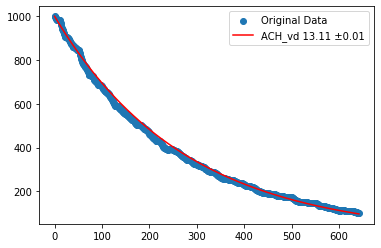

In [575]:
# begin window search at `col_fit` max
pm25_max_idx = df.idxmax()[col_fit]
if pm25_max_idx != 0:
    df = df.tail(-pm25_max_idx).copy()
    df.index -= df.index[0]
    df['time'] -= df.time[0]

# cut off all records before `col_fit` dropped to `fit_under`
drop_start_idx = df[df[col_fit] <= fit_under].index[0]
if drop_start_idx != 0:
    df = df.tail(-drop_start_idx).copy()
    df.index -= df.index[0]
    df['time'] -= df.time[0]

# cut off all records after `col_fit` dropped below `fit_over`
lt25_iloc = df[df[col_fit] < fit_over].index[0]
df = df.head(lt25_iloc).copy()

print('num data points to fit: {}'.format(len(df)))

C_pt0, popt, naturaldecay_stderr = test_fit(df)
ACH_vd = popt[0]
print('C_pt0: {}'.format(C_pt0))
print('ACH_vd: {}'.format(ACH_vd))
print('stderr: {}'.format(naturaldecay_stderr))

f = DecayFuncs(0, C_pt0)

plt.scatter(df.time, df[col_fit], label="Original Data")
plt.plot(df.time, f.func(df.time, ACH_vd), 'r-', label="ACH_vd {:0.2f} ±{:0.2f}".format(ACH_vd, naturaldecay_stderr))
plt.legend()


# Trial

1. Set `filename` to one of the air purifier trials from the experiment.

In [576]:
filename = 'data_mesh/20221218_HealthyGlow_4LianLiST120+3ArcticP12.trial7.vd_first.csv'

if filename.endswith('.edf'):
    df = pd.read_csv(filename, sep='\t', skiprows=9)
    df.rename(columns = {'Epoch_UTC': 'time'}, inplace=True)
    # set time off of zero rather than epoch
    time_offset = df.time[0]
    df['time'] -= time_offset
else:
    df = pd.read_csv(filename)
    print('F°: {}'.format(df['temp_F'][10]))
    print('C°: {}'.format(df['temp_C'][10]))
    print('rh: {}%'.format(df.rh[10]))

# plot the original data
df.drop([x for x in df.columns.values.tolist() if x not in [col_fit, 'time']], axis=1).set_index('time').plot(title='Trial', kind='line')

F°: 74.35
C°: 23.53
rh: 39.32%


num data points to fit: 51
C_pt0: 975
ACH: 164.93900680333664
stderr: 1.1723989349023245


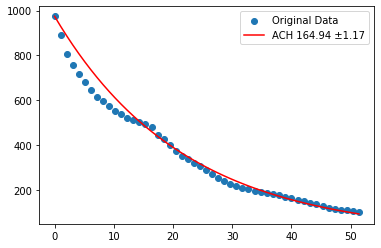

In [577]:
# begin window search at `col_fit` max
pm25_max_idx = df.idxmax()[col_fit]
if pm25_max_idx != 0:
    df = df.tail(-pm25_max_idx).copy()
    df.index -= df.index[0]
    df['time'] -= df.time[0]

# cut off all records before `col_fit` dropped to `fit_under`
drop_start_idx = df[df[col_fit] <= fit_under].index[0]
if drop_start_idx != 0:
    df = df.tail(-drop_start_idx).copy()
    df.index -= df.index[0]
    df['time'] -= df.time[0]

# cut off all records after `col_fit` dropped below `fit_over`
lt25_iloc = df[df[col_fit] < fit_over].index[0]
df = df.head(lt25_iloc).copy()

print('num data points to fit: {}'.format(len(df)))

C_pt0, popt, totaldecay_stderr = test_fit(df)
ACH = popt[0]
print('C_pt0: {}'.format(C_pt0))
print('ACH: {}'.format(ACH))
print('stderr: {}'.format(totaldecay_stderr))

f = DecayFuncs(0, C_pt0)

plt.scatter(df.time, df[col_fit], label="Original Data")
plt.plot(df.time, f.func(df.time, ACH), 'r-', label="ACH {:0.2f} ±{:0.2f}".format(ACH, totaldecay_stderr))
plt.legend()


In [578]:
# print summary statistics for 'typical' column, these describe average particle size
print(df.drop([x for x in df.columns.values.tolist() if x not in ['typical']], axis=1).describe())

# create dataframe of particle size buckets
df_dist = pd.DataFrame(columns=['time', '0.3-0.5', '0.5-1.0', '1.0-2.5', '2.5-4.0', '4.0-10'])
df_dist['time'] = df.time.copy()
df_dist['0.3-0.5'] = df['nPM0.5'].copy()
df_dist['0.5-1.0'] = df['nPM1.0'] - df['nPM0.5']
df_dist['1.0-2.5'] = df['nPM2.5'] - df['nPM1.0']
df_dist['2.5-4.0'] = df['nPM4.0'] - df['nPM2.5']
df_dist['4.0-10'] = df['nPM10'] - df['nPM4.0']

df_dist.set_index('time').plot(title='Distribution Buckets', kind='line', labels= {'value': 'Number Concentration (#/cm³)'})


           typical
count    51.000000
mean    970.313725
std      30.824984
min     921.000000
25%     942.500000
50%     968.000000
75%     992.000000
max    1040.000000


For this next part don't forget to change V_r (Volume of room/chamber) to match your value.

stderr (ACH): 1.1723989349023245
CADR 371.11 ±2.87


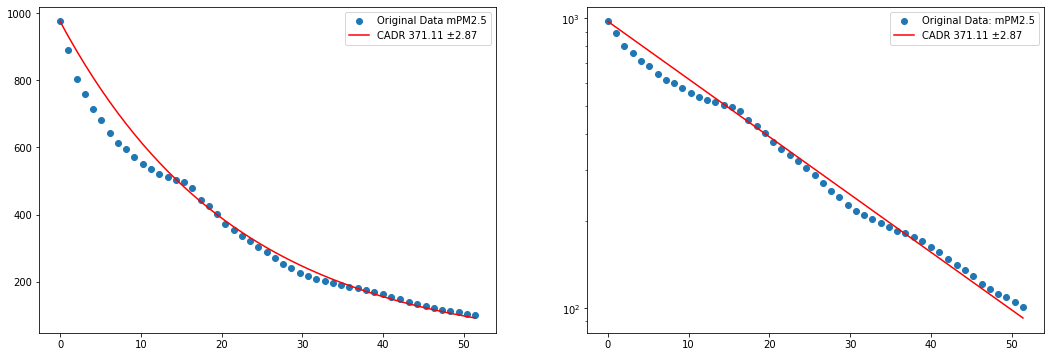

In [579]:
ACH_f = ACH - ACH_vd
# volume of room
V_r = (59. / 12) * (59. / 12) * (72.8 / 12) # this is in cubic feet
CADR = V_r * ACH_f / 60 # units of ACH are 1/h, divide by 60 to convert to 1/minutes so CADR is in cubic feet per minute
CADR_err = V_r * np.sqrt((naturaldecay_stderr/60)**2 + (totaldecay_stderr/60)**2)

print('stderr (ACH): {}'.format(totaldecay_stderr))
print("CADR {:0.2f} ±{:0.2f}".format(CADR, CADR_err))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

plt.subplot(121)
plt.scatter(df.time, df[col_fit], label="Original Data {}".format(col_fit))
plt.plot(df.time, f.func(df.time, ACH), 'r-', label="CADR {:0.2f} ±{:0.2f}".format(CADR, CADR_err))
plt.legend()

plt.subplot(122)
plt.scatter(df.time, df[col_fit], label="Original Data: {}".format(col_fit))
plt.plot(df.time, f.func(df.time, ACH), 'r-', label="CADR {:0.2f} ±{:0.2f}".format(CADR, CADR_err))
plt.yscale('log')
plt.legend()
#fig.suptitle('Sensirion SPS30 Trial 3')
plt.show()

Collect results of each trial here in `trials` to get the mean and standard error of the mean

In [581]:
trials = [354.12, 363.16, 362.38, 347.16, 345.21, 354.81, 371.11]

print('mean of trials: {}'.format(np.mean(trials)))
print('std error of the mean: {}'.format(scipy.stats.sem(trials)))
print('{:.1f} ±{:.2f}'.format(np.mean(trials), scipy.stats.sem(trials)))

print()
print('natural decay std dev:', naturaldecay_stderr / 60)
print('total decay std dev:', totaldecay_stderr / 60)
S_CADR = V_r * np.sqrt((naturaldecay_stderr/60)**2 + (totaldecay_stderr/60)**2)
print('Standard error estimate of CADR by error propogation analysis: {}'.format(S_CADR))

mean of trials: 356.85
std error of the mean: 3.5008325540403367
356.9 ±3.50

natural decay std dev: 0.00023919872040345877
total decay std dev: 0.019539982248372074
Standard error estimate of CADR by error propogation analysis: 2.8658164241486483
